In [102]:
using ITensors
using Plots
using JLD2
using Base.Threads
using StatsBase
using HDF5
include("../sampling.jl");

In [2]:
function loadMPS(path::String; id::String="W")
    """Loads an MPS from a .h5 file. Returns and ITensor MPS."""
    file = path[end-2:end] != ".h5" ? path * ".h5" : path
    f = h5open("$file","r")
    mps = read(f, "$id", MPS)
    close(f)
    return mps
end
function sliceMPS(W::MPS, class_label::Int)
    """General function to slice the MPS and return the state corresponding to a specific class label."""
    ψ = deepcopy(W)
    decision_idx = findindex(ψ[end], "f(x)")
    decision_state = onehot(decision_idx => (class_label + 1))
    ψ[end] *= decision_state
    normalize!(ψ) # same step as before - normalise the tensor at the site with the label index instead?

    return ψ
end;

In [3]:
mps_loaded = loadMPS("/Users/joshua/Documents/QuantumInspiredML/LogLossAlternative/generative_experiment/saved_data/1000_samples/chi100_mps.h5");

In [4]:
norm(mps_loaded)

1.0000000000000047

In [5]:
state0 = sliceMPS(mps_loaded, 0)
state1 = sliceMPS(mps_loaded, 1);

In [6]:
all_shots_c0 = Matrix{Float64}(undef, 5000, 100)
for i in 1:5000
    println(i)
    all_shots_c0[i, :] = sample_mps_with_contractions(state0)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
mean_ts = mean(all_shots_c0, dims=1)[1,:]
std_ts = std(all_shots_c0, dims=1)[1,:]

100-element Vector{Float64}:
 0.28149126415173603
 0.2838979991398918
 0.2839467872341276
 0.2837522790544941
 0.28213086728559456
 0.28067799140368754
 0.2827964534176395
 0.2846056927368233
 0.2832571267293337
 0.283413005350692
 ⋮
 0.28493361177943805
 0.2828344088800649
 0.2822104771968485
 0.2817473158331648
 0.28590800016430046
 0.2852250619481189
 0.2829443386561351
 0.2856010637725539
 0.28053848782279234

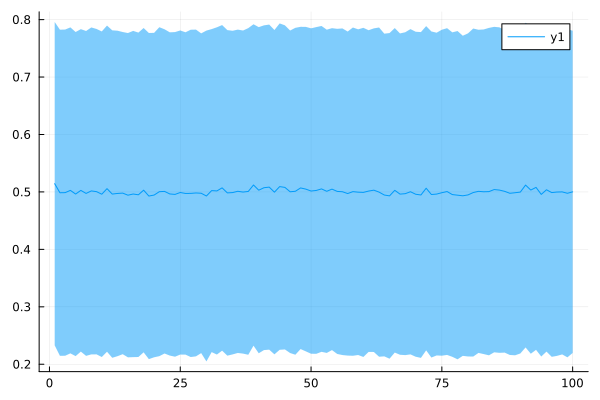

In [13]:
plot(mean_ts, ribbon=std_ts)

In [10]:
@load "train_chi50.jld2"

2-element Vector{Symbol}:
 :X_train_scaled
 :y_train

In [11]:
c0_idxs = findall(x -> x.== 0, y_train);
c1_idxs = findall(x -> x.== 1, y_train);
c0_samples = X_train_scaled[c0_idxs, :];
c1_samples = X_train_scaled[c1_idxs, :];

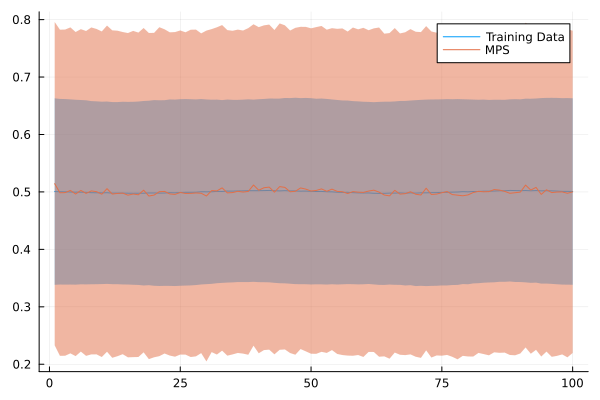

In [17]:
plot(mean(c0_samples, dims=1)[1,:], ribbon=std(c0_samples, dims=1)[1,:], label="Training Data")
plot!(mean_ts, ribbon=std_ts, label="MPS")

In [7]:
@load "/Users/joshua/Documents/QuantumInspiredML/LogLossAlternative/generative_experiment/saved_data/1000_samples/chi100_test.jld2"

2-element Vector{Symbol}:
 :X_test_scaled
 :y_test

In [8]:
c0_test_idxs = findall(x -> x.== 0, y_test);
c1_test_idxs = findall(x -> x.== 1, y_test);
c0_test_samples = X_test_scaled[c0_test_idxs, :];
c1_test_samples = X_test_scaled[c1_test_idxs, :];

In [57]:
all_shots_forecast100 = Matrix{Float64}(undef, 100, 100)
for i in 1:100
    all_shots_forecast100[i, :] = forecast_mps_sites(state0, c0_test_samples[19,1:50], 51)
end
all_shots_forecast500 = Matrix{Float64}(undef, 500, 100)
for i in 1:500
    all_shots_forecast500[i, :] = forecast_mps_sites(state0, c0_test_samples[19,1:50], 51)
end
all_shots_forecast1000 = Matrix{Float64}(undef, 1000, 100)
for i in 1:1000
    all_shots_forecast1000[i, :] = forecast_mps_sites(state0, c0_test_samples[19,1:50], 51)
end

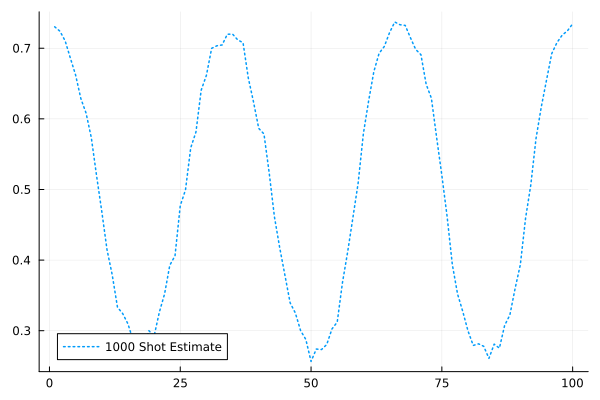

In [75]:
#plot(mean(all_shots_forecast100, dims=1)[1,:], label="100 Shot Estimate", lw=1.5, ls=:dot)
#plot!(mean(all_shots_forecast500, dims=1)[1,:], label="500 Shot Estimate", lw=1.5, ls=:dot)
plot(mean(all_shots_forecast1000, dims=1)[1,:], label="1000 Shot Estimate", lw=1.5, ls=:dot)

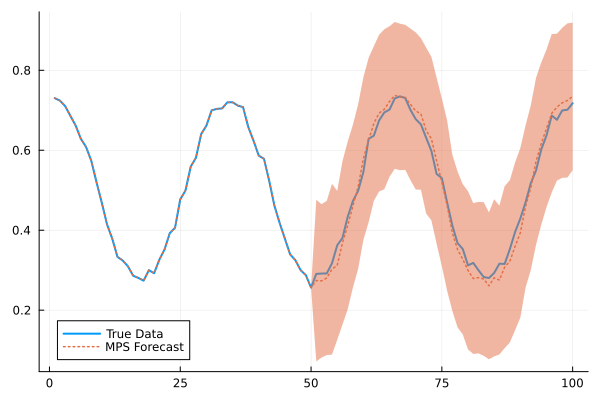

In [78]:
plot(c0_test_samples[19,:], lw=2, label="True Data")
plot!(mean(all_shots_forecast1000, dims=1)[1,:], ribbon=std(all_shots_forecast1000, dims=1)[1,:], label="MPS Forecast", lw=1.5, ls=:dot)

In [111]:
fcast = mean(all_shots_forecast500, dims=1)[1,:]

100-element Vector{Float64}:
 0.7303649286846832
 0.724128491955174
 0.7104286864209732
 0.6859320104000658
 0.6619686212974097
 0.6287114017017498
 0.6080829776391046
 0.5733681649089135
 0.5196983859527147
 0.4689029055705381
 ⋮
 0.5125546503155378
 0.5872844017974208
 0.6105819423653917
 0.6430702882236667
 0.70223152949785
 0.7000408593128762
 0.7131364342049753
 0.7352219860565398
 0.7233287684241447

In [112]:
compute_mape(fcast[51:end], c0_test_samples[19, 51:end]; symmetric=true)

0.046372789766722225

In [48]:
all_shots_forecast1000 = Matrix{Float64}(undef, 1000, 100)
for i in 1:1000
    all_shots_forecast1000[i, :] = forecast_mps_sites(state1, c1_test_samples[34,1:50], 51)
end

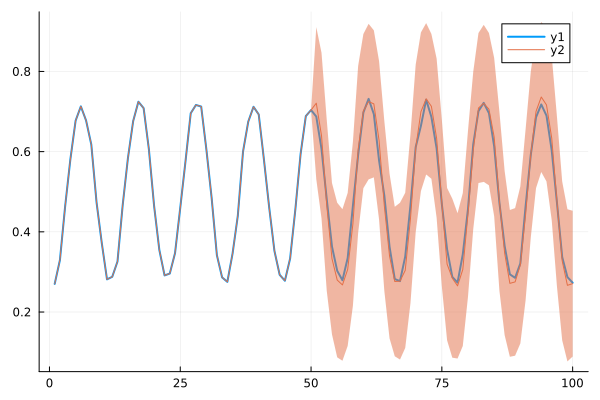

In [51]:
plot(c1_test_samples[34,:], lw=2)
plot!(mean(all_shots_forecast1000, dims=1)[1,:], ribbon=std(all_shots_forecast1000, dims=1)[1,:])